In [1]:
#! pip install --upgrade --quiet category_encoders

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
color = sns.color_palette()

from dateutil.parser import parse 
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.holtwinters import ExponentialSmoothing,Holt,SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#read clean dataset

In [3]:
clean_df= pd.read_csv('/content/drive/MyDrive/Capstone Project/Data Files/Bank Loan Default_CleanBaseLine_v2.0.csv')
clean_df.shape
clean_df.info()
clean_df['issue_d']= pd.to_datetime(clean_df['issue_d'], format='%b-%y')
clean_df['earliest_cr_line']= pd.to_datetime(clean_df['earliest_cr_line'], format='%b-%y')
clean_df['last_pymnt_d']= pd.to_datetime(clean_df['last_pymnt_d'], format='%b-%y')
clean_df['last_credit_pull_d']= pd.to_datetime(clean_df['last_credit_pull_d'], format='%b-%y')
clean_df.info()
clean_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119145 entries, 0 to 119144
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   member_id               119145 non-null  int64  
 1   loan_amnt               119145 non-null  int64  
 2   funded_amnt             119145 non-null  int64  
 3   funded_amnt_inv         119145 non-null  float64
 4   term                    119145 non-null  object 
 5   int_rate                119145 non-null  float64
 6   installment             119145 non-null  float64
 7   grade                   119145 non-null  object 
 8   emp_length              119145 non-null  int64  
 9   home_ownership          119145 non-null  object 
 10  annual_inc              119145 non-null  float64
 11  verification_status     119145 non-null  object 
 12  issue_d                 119145 non-null  object 
 13  pymnt_plan              119145 non-null  object 
 14  purpose             

member_id                 0
loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
pymnt_plan                0
purpose                   0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
mths_since_last_delinq    0
open_acc                  0
revol_bal                 0
revol_util                0
total_acc                 0
out_prncp                 0
out_prncp_inv             0
total_pymnt               0
total_pymnt_inv           0
total_rec_prncp           0
total_rec_int             0
total_rec_late_fee        0
last_pymnt_d              0
last_pymnt_amnt           0
last_credit_pull_d        8
loan_status         

#Drop Missing elements rows

In [4]:
clean_df=clean_df.dropna()
clean_df.info()
clean_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119137 entries, 0 to 119144
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   member_id               119137 non-null  int64         
 1   loan_amnt               119137 non-null  int64         
 2   funded_amnt             119137 non-null  int64         
 3   funded_amnt_inv         119137 non-null  float64       
 4   term                    119137 non-null  object        
 5   int_rate                119137 non-null  float64       
 6   installment             119137 non-null  float64       
 7   grade                   119137 non-null  object        
 8   emp_length              119137 non-null  int64         
 9   home_ownership          119137 non-null  object        
 10  annual_inc              119137 non-null  float64       
 11  verification_status     119137 non-null  object        
 12  issue_d                 119137

member_id                 0
loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
pymnt_plan                0
purpose                   0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
mths_since_last_delinq    0
open_acc                  0
revol_bal                 0
revol_util                0
total_acc                 0
out_prncp                 0
out_prncp_inv             0
total_pymnt               0
total_pymnt_inv           0
total_rec_prncp           0
total_rec_int             0
total_rec_late_fee        0
last_pymnt_d              0
last_pymnt_amnt           0
last_credit_pull_d        0
loan_status         

In [5]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

     issue_d  loan_amnt
0 2011-12-01       5000
1 2011-12-01       2400
2 2011-12-01      10000
3 2011-12-01       5000
4 2011-12-01       3000
            loan_amnt
issue_d              
2007-06-01       7500
2007-07-01     171700
2007-08-01     157350
2007-09-01     115900
2007-10-01     249075
...               ...
2013-08-01   73438900
2013-09-01   74783450
2013-10-01   79175775
2013-11-01   80832025
2013-12-01   83049250

[74 rows x 1 columns]
     issue_d    loan_amnt
0 2007-06-01  7500.000000
1 2007-07-01  5723.333333
2 2007-08-01  6051.923077
3 2007-09-01  7726.666667
4 2007-10-01  6731.756757
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   issue_d    74 non-null     datetime64[ns]
 1   loan_amnt  74 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB
<class 'pandas.core.frame.DataFrame'>
Int6

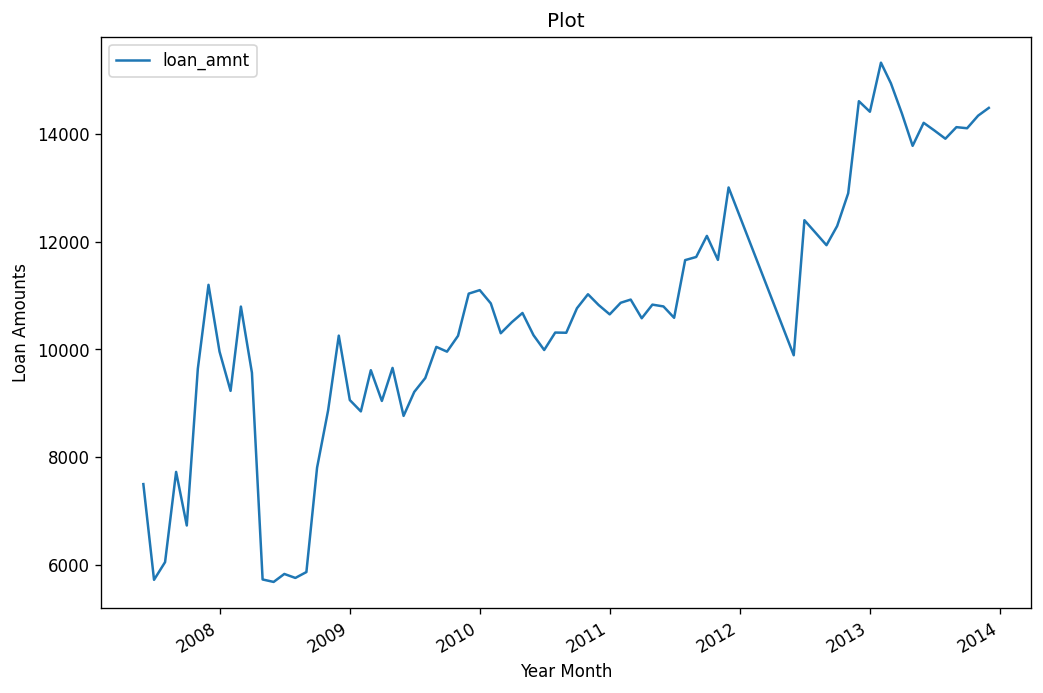

In [6]:
Loan_Df=clean_df[['issue_d', 'loan_amnt']]
print(Loan_Df.head())
print(Loan_Df.groupby('issue_d').sum())
mean_Loan_Df= Loan_Df.groupby(['issue_d'], as_index = False).mean()
print(mean_Loan_Df.head())
mean_Loan_Df.info()
mean_Loan_Df['issue_d'] = pd.to_datetime(mean_Loan_Df['issue_d'])
mean_Loan_Df.info()
mean_Loan_Df.set_index('issue_d', inplace=True)
mean_Loan_Df.head()
mean_Loan_Df.plot(title='Plot',xlabel="Year Month", ylabel='Loan Amounts');

     issue_d  loan_amnt
0 2011-12-01       5000
1 2011-12-01       2400
2 2011-12-01      10000
3 2011-12-01       5000
4 2011-12-01       3000
            loan_amnt
issue_d              
2007-06-01       7500
2007-07-01     171700
2007-08-01     157350
2007-09-01     115900
2007-10-01     249075
...               ...
2013-08-01   73438900
2013-09-01   74783450
2013-10-01   79175775
2013-11-01   80832025
2013-12-01   83049250

[74 rows x 1 columns]
     issue_d  loan_amnt
0 2007-06-01       7500
1 2007-07-01     171700
2 2007-08-01     157350
3 2007-09-01     115900
4 2007-10-01     249075
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   issue_d    74 non-null     datetime64[ns]
 1   loan_amnt  74 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 ent

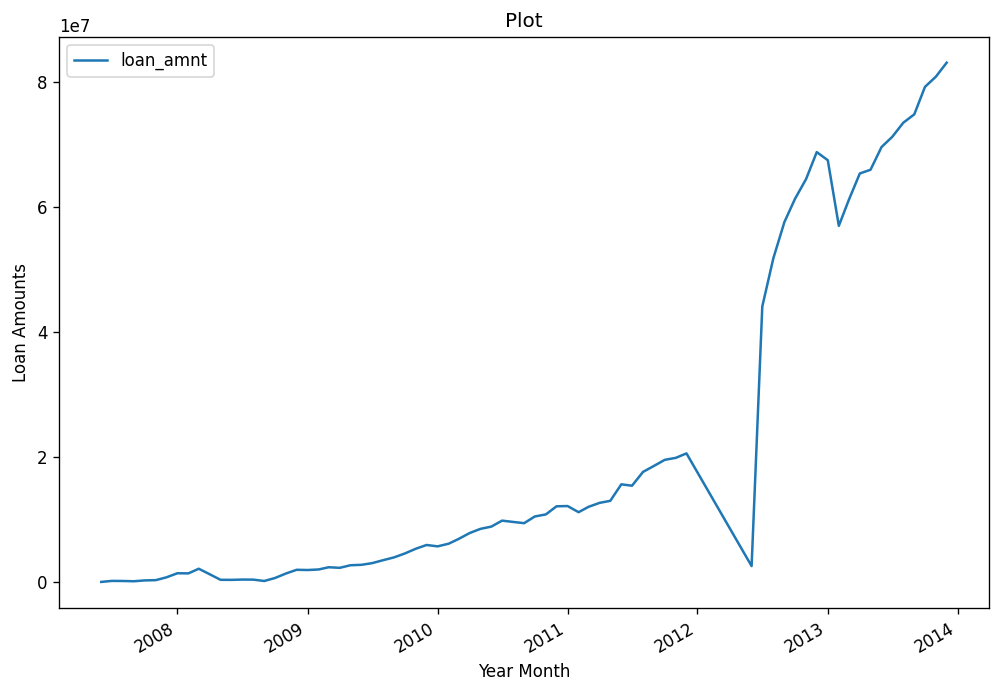

In [7]:
Loan_Df=clean_df[['issue_d', 'loan_amnt']]
print(Loan_Df.head())
print(Loan_Df.groupby('issue_d').sum())
sum_Loan_Df= Loan_Df.groupby(['issue_d'], as_index = False).sum()
print(sum_Loan_Df.head())
sum_Loan_Df.info()
sum_Loan_Df['issue_d'] = pd.to_datetime(sum_Loan_Df['issue_d'])
sum_Loan_Df.info()
sum_Loan_Df.set_index('issue_d', inplace=True)
sum_Loan_Df.head()
sum_Loan_Df.plot(title='Plot',xlabel="Year Month", ylabel='Loan Amounts');

     issue_d   total_pymnt
0 2011-12-01   5861.071414
1 2011-12-01   3003.653644
2 2011-12-01  12226.302210
3 2011-12-01   5631.377753
4 2011-12-01   3938.144334
     issue_d  total_pymnt
0 2007-06-01  9194.980000
1 2007-07-01  6501.383667
2 2007-08-01  6853.833077
3 2007-09-01  8713.291333
4 2007-10-01  7162.364054
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   issue_d      74 non-null     datetime64[ns]
 1   total_pymnt  74 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   issue_d      74 non-null     datetime64[ns]
 1   total_pymnt  74 non-null     float64       
dtypes: datetime64[ns](1), 

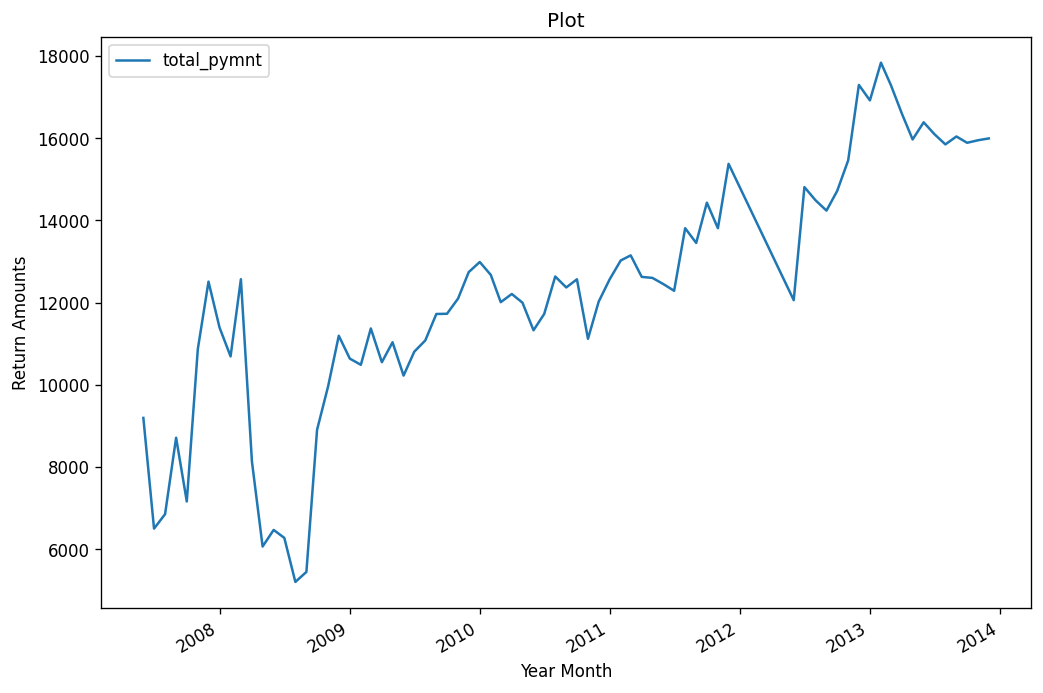

In [8]:
LoanReturn_Df=clean_df[['issue_d', 'total_pymnt']]
print(LoanReturn_Df.head())
sum_LoanReturn_Df= LoanReturn_Df.groupby(['issue_d'], as_index = False).mean()
print(sum_LoanReturn_Df.head())
sum_LoanReturn_Df.info()
sum_LoanReturn_Df['issue_d'] = pd.to_datetime(sum_LoanReturn_Df['issue_d'])
sum_LoanReturn_Df.info()
sum_LoanReturn_Df.set_index('issue_d', inplace=True)
sum_LoanReturn_Df.plot(title='Plot',xlabel="Year Month", ylabel='Return Amounts');

     issue_d  loan_amnt  ...  total_rec_int  total_rec_late_fee
0 2011-12-01       5000  ...         861.07                0.00
1 2011-12-01       2400  ...         603.65                0.00
2 2011-12-01      10000  ...        2209.33               16.97
3 2011-12-01       5000  ...         631.38                0.00
4 2011-12-01       3000  ...         938.14                0.00

[5 rows x 6 columns]
     issue_d    loan_amnt  ...  total_rec_int  total_rec_late_fee
0 2007-06-01  7500.000000  ...    1694.980000            0.000000
1 2007-07-01  5723.333333  ...     777.551333            0.499074
2 2007-08-01  6051.923077  ...     801.146923            0.763077
3 2007-09-01  7726.666667  ...     980.625333            5.999302
4 2007-10-01  6731.756757  ...     949.531351            4.048967

[5 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------       

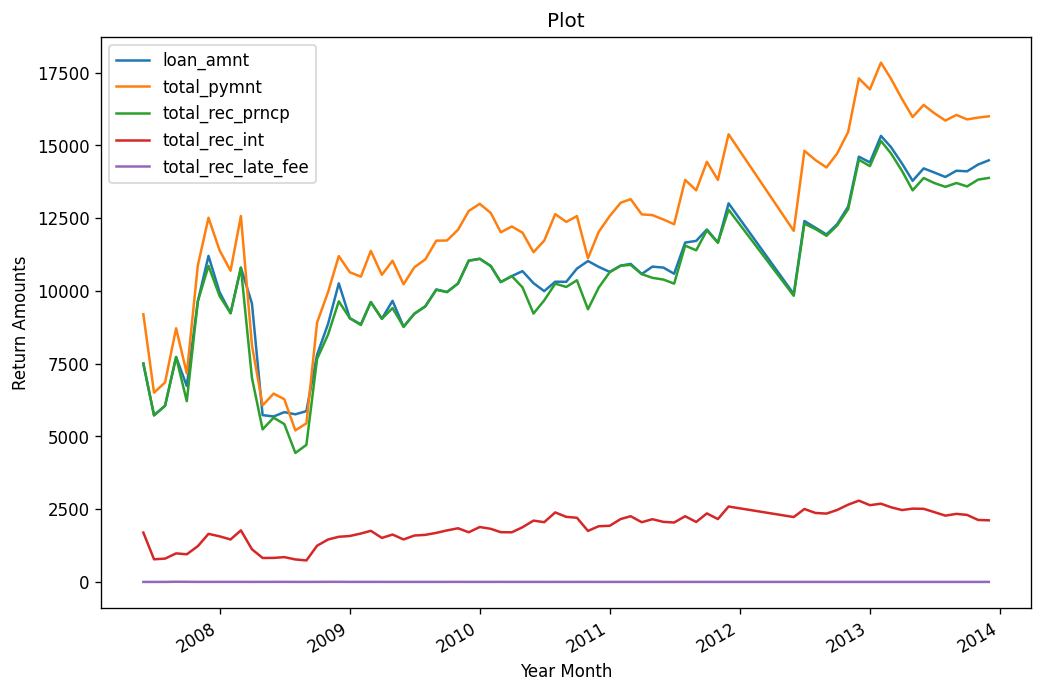

In [9]:
LoanReturnParams_Df=clean_df[['issue_d','loan_amnt','total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee']]
print(LoanReturnParams_Df.head())
sum_LoanReturnParams_Df= LoanReturnParams_Df.groupby(['issue_d'], as_index = False).mean()
print(sum_LoanReturnParams_Df.head())
sum_LoanReturnParams_Df.info()
sum_LoanReturnParams_Df['issue_d'] = pd.to_datetime(sum_LoanReturnParams_Df['issue_d'])
sum_LoanReturnParams_Df.info()
sum_LoanReturnParams_Df.set_index('issue_d', inplace=True)
sum_LoanReturnParams_Df.plot(title='Plot',xlabel="Year Month", ylabel='Return Amounts');

In [10]:
LoanDefaults_Df=clean_df[['loan_amnt','loan_status']]
print(LoanDefaults_Df.head())
sum_LoanReturnParams_Df= LoanDefaults_Df.groupby(['loan_status'], as_index = False).sum()
print(sum_LoanReturnParams_Df.head())
sum_LoanReturnParams_Df.info()

Df2= clean_df[['issue_d','loan_amnt','loan_status']]

Df3 = Df2.groupby(['issue_d','loan_status'], as_index=False)['loan_amnt'].sum()

print(Df3)
Df3.head()

   loan_amnt loan_status
0       5000  Fully Paid
1       2400  Fully Paid
2      10000  Fully Paid
3       5000  Fully Paid
4       3000  Fully Paid
  loan_status   loan_amnt
0     Default    52272300
1  Fully Paid  1494522225
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   loan_status  2 non-null      object
 1   loan_amnt    2 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 48.0+ bytes
       issue_d loan_status  loan_amnt
0   2007-06-01  Fully Paid       7500
1   2007-07-01  Fully Paid     171700
2   2007-08-01  Fully Paid     157350
3   2007-09-01  Fully Paid     115900
4   2007-10-01  Fully Paid     249075
..         ...         ...        ...
105 2013-10-01  Fully Paid   73826575
106 2013-11-01     Default    5362275
107 2013-11-01  Fully Paid   75469750
108 2013-12-01     Default    6122775
109 2013-12-01  Fully Paid   7692647

,issue_d,loan_status,loan_amnt
0,2007-06-01,Fully Paid,7500
1,2007-07-01,Fully Paid,171700
2,2007-08-01,Fully Paid,157350
3,2007-09-01,Fully Paid,115900
4,2007-10-01,Fully Paid,249075


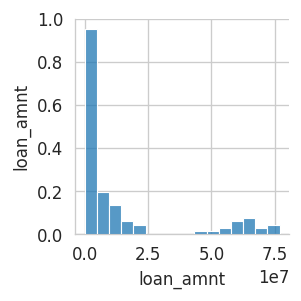

In [11]:
sns.set_style("whitegrid");
sns.pairplot(Df3);
plt.show()